In [1]:
import sys
sys.path.insert(0, "..")
from pathlib import Path
import re
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
import polars as pl

BENCHMARK = 'pmem2bench'

def pretty_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:3.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

FIG_DIR = Path(f'../fig/{BENCHMARK}').resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
def save(fig, name):
    for ext in ('png', 'eps', 'pdf'):
        fig.savefig(FIG_DIR / f'{name}.{ext}', bbox_inches = 'tight')
    # pass 

In [2]:
RAW_BASEDIR=Path("../raw/")

default_params = {
    "version": "0.1.0",
    "noflush": False,
    "paddingSize": 0,
    "nsegments": 1,
}

job_group = (
    ("pegasus/pmem2bench/2023.06.22-18.16.11", {"platform": "pegasus", "loadApi": "libc"}),
    ("pegasus/pmem2bench/2023.06.22-19.16.25", {"platform": "pegasus", "loadApi": "libc"}),
    ("pegasus/pmem2bench/2023.06.23-12.22.20", {"platform": "pegasus", "loadApi": "libc"}),
    ("pegasus/pmem2bench/2023.07.02-18.03.12", {"platform": "pegasus", "loadApi": "libpmem2"}),
    ("pegasus/pmem2bench/2023.07.03-10.40.39", {"platform": "pegasus", "loadApi": "libpmem2"}),
    # ("chris90/pmem2bench/2023.06.23-18.02.15", {"platform": "chris90", "loadApi": "libc"}),
    # ("chris80/pmem2bench/2023.06.30-15.23.45", {"platform": "chris80", "loadApi": "libc"}),
    ("chris90/pmem2bench/2023.07.02-13.56.01", {"platform": "chris90", "loadApi": "libpmem2"}),
    ('chris90/pmem2bench/2023.07.03-11.07.22', {"platform": "chris90", "loadApi": "libpmem2"}),
    ("chris80/pmem2bench/2023.07.02-13.55.20", {"platform": "chris80", "loadApi": "libpmem2"}), # read w/ flush
    ('chris80/pmem2bench/2023.07.03-11.08.54', {"platform": "chris80", "loadApi": "libpmem2"}), # read w/o flush
    # ("cygnus/pmem2bench/2023.06.23-14.34.22", {"platform": "cygnus", "loadApi": "libc"}),
    # ('pegasus/pmem2bench/2023.07.14-16.36.32', {"platform": "pegasus", "loadApi": "libpmem2"}), # noflush/nodrain store
    # ('pegasus/pmem2bench/2023.07.14-17.08.28', {"platform": "pegasus", "loadApi": "libpmem2"}), # noflush store
    # ("chris80/pmem2bench/2023.07.18-11.43.04", {"platform": "chris80", "loadApi": "libpmem2"}), # 6 GiB / thread, bank conflict
    # --v0.2.0--
    # ('pegasus/pmem2bench/2023.07.18-14.09.10', {"platform": "pegasus", "loadApi": "libpmem2"}), # noflush/nodrain store
    # ('pegasus/pmem2bench/2023.07.18-14.25.02', {"platform": "pegasus", "loadApi": "libpmem2"}), # t-store
    # ('pegasus/pmem2bench/2023.07.18-15.25.31', {"platform": "pegasus", "loadApi": "libpmem2"}), # nt-store
    # ('pegasus/pmem2bench/2023.07.18-16.02.41', {"platform": "pegasus", "loadApi": "libpmem2"}), # padding 2M
    # ('pegasus/pmem2bench/2023.07.18-17.13.02', {"platform": "pegasus", "loadApi": "libpmem2"}), # padding 4K
    # ('pegasus/pmem2bench/2023.07.18-17.20.58', {"platform": "pegasus", "loadApi": "libpmem2"}), # padding 2M + 4K
    # ('chris90/pmem2bench/2023.07.18-14.27.12', {"platform": "chris90", "loadApi": "libpmem2"}), # padding 4K
    # ('chris80/pmem2bench/2023.07.18-15.12.08', {"platform": "chris80", "loadApi": "libpmem2"}), # padding 4K
    # ('chris80/pmem2bench/2023.07.18-19.58.03', {"platform": "chris80", "loadApi": "libpmem2"}), # padding 16K, bank conflict
)

def parse_result(json_file: Path):
    with json_file.open() as f:
        return json.load(f)


re_iter = re.compile(r"_([0-9]+)\.json")
def parse_iter_from_filename(json_file: Path):
    m = re_iter.search(json_file.name)
    if m:
        return int(m.groups()[0])
    else:
        raise Exception("parse error: iteration")

failed_job_count = 0
job_params = []
job_results = []
for job_dir, meta_overwrite in job_group:
    job_dir = RAW_BASEDIR / job_dir
    for job_file in job_dir.glob("*.json"):
        try:
            parsed = parse_result(job_file)
            job_params.append({
                **default_params,
                **parsed["params"],
                "iter": parse_iter_from_filename(job_file),
                **meta_overwrite,
            })
            job_results.append(parsed["results"])
        except Exception as e:
            print(f"{job_file}: {e}")
            failed_job_count += 1
print(f"failed: {failed_job_count}")

df_params = pd.DataFrame(job_params)

df_params["device"] = np.select([
    (df_params.platform == "pegasus"),
    (df_params.platform == "chris90"),
    (df_params.platform.isin(["cygnus", "chris80"])),
], [
    "Optane 300",
    "Optane 200",
    "Optane 100",
],
default="unknown")

df_params["ndimms"] = np.select([
    (df_params.platform.isin(["pegasus", "chris90"])),
    (df_params.platform.isin(["cygnus", "chris80"])),
], [
    8,
    6, # num of dimms per socket
])

df_params["api"] = np.select([
    (df_params.accessType == "write") | (df_params.loadApi == "libpmem2"),
    (df_params.loadApi == "libc"),
], [
    "libpmem2",
    "libc",
],
default="unknown")

df_params["bankConflict"] = (df_params.stripeSize // df_params.nthreads + df_params.paddingSize) % (df_params.ndimms * 4*1024) == 0

# If loadApi is libc, it is not actually using a non-temporal store
df_params.loc[(df_params.api == "libc"), "nonTemporal"] = False
df_params.loc[(df_params.api == "libc"), "noflush"] = True

df_results = pd.DataFrame(job_results)
df_src = df_params.join(df_results)

# filtering
df_filtered = df_src.query("not (accessType == 'read' and noflush == False)")

failed: 0


In [3]:
df = df_filtered
# df = df_src

groupby = ["success", "platform", "source", "accessType", "api", "accessPattern", "nonTemporal", "noflush", "bankConflict"]
grouper = df.drop(["path", "granularity", "set-affinity"], axis=1).groupby(groupby)
pd.set_option('display.max_rows', 250)
display(grouper.size())
pd.set_option('display.max_rows', 50)

success  platform  source  accessType  api       accessPattern  nonTemporal  noflush  bankConflict
True     chris80   devdax  read        libpmem2  random         False        True     False           225
                                                 sequential     False        True     False           225
                           write       libpmem2  random         False        False    False           450
                                                                True         False    False           450
                                                 sequential     False        False    False           450
                                                                True         False    False           450
         chris90   devdax  read        libpmem2  random         False        True     True            225
                                                 sequential     False        True     True            225
                           write       libpmem2  rand

In [4]:
df = df_filtered

# remove fsdax && iter=1 && write
# df = df.drop(df[(df.source == "fsdax") & (df.accessType == "write") & (df.iter == 1)].index)

default_groupby = ["success", "platform", "source", "accessType", "api", "accessPattern", "nonTemporal", "noflush", "nthreads", "blockSize", "bankConflict"]
grouper = df.drop(["path", "granularity", "set-affinity"], axis=1).groupby(default_groupby)

pd.set_option('display.max_rows', 50)
iters = grouper.size()
iters[iters < 3]

success  platform  source  accessType  api       accessPattern  nonTemporal  noflush  nthreads  blockSize  bankConflict
True     pegasus   anon    write       libpmem2  random         False        False    16        256        True            1
                                                                                                512        True            2
dtype: int64

In [5]:
# calc parallel performance
df = (
    grouper.max().reset_index()
)
df["GiB/s"] = df["byte_per_sec"] / 2**30

df_merged = pd.merge(
    df,
    df.query("nthreads==1").rename(columns={"GiB/s": "base", "nthreads": "nthreads_right"}),
    how='left', on=[i for i in default_groupby if i not in ["nthreads"]])
df_merged["speedup"] = df_merged["GiB/s"] / df_merged["base"]
df_merged["parallel_perf"] = df_merged["speedup"] / df_merged["nthreads"]
df_merged = df_merged[default_groupby + ["GiB/s", "speedup", "parallel_perf"]]

pd.set_option('display.max_rows', 250)

display(
    df_merged
    .query(
        "platform == 'pegasus' and source == 'devdax' and api == 'libpmem2'"
        " and accessPattern == 'sequential' and accessType == 'write' and nonTemporal == True and noflush == False"
        " and bankConflict==True"
        " and blockSize == 64"
    )
)

pd.set_option('display.max_rows', 50)


,success,platform,source,accessType,api,accessPattern,nonTemporal,noflush,nthreads,blockSize,bankConflict,GiB/s,speedup,parallel_perf
2074,True,pegasus,devdax,write,libpmem2,sequential,True,False,1,64,True,0.246692,1.000000,1.000000
2089,True,pegasus,devdax,write,libpmem2,sequential,True,False,2,64,True,0.493067,1.998720,0.999360
2104,True,pegasus,devdax,write,libpmem2,sequential,True,False,4,64,True,0.985045,3.993022,0.998256
2119,True,pegasus,devdax,write,libpmem2,sequential,True,False,8,64,True,1.965150,7.966022,0.995753
2134,True,pegasus,devdax,write,libpmem2,sequential,True,False,16,64,True,3.911588,15.856193,0.991012
2149,True,pegasus,devdax,write,libpmem2,sequential,True,False,32,64,True,7.732650,31.345426,0.979545
2164,True,pegasus,devdax,write,libpmem2,sequential,True,False,48,64,True,11.386552,46.157048,0.961605


('chris80', 'devdax', 'write', 'libpmem2', 'sequential', np.True_, np.False_, np.False_)


/tmp/ipykernel_8329/1275652942.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


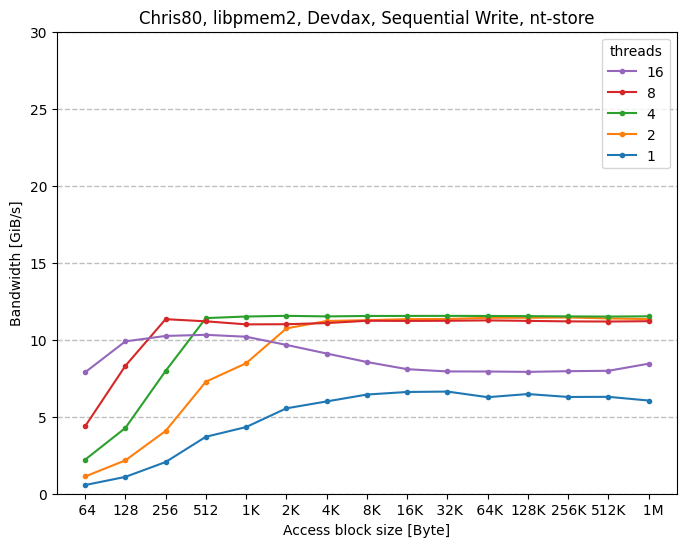

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_8329/1275652942.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


('chris90', 'devdax', 'write', 'libpmem2', 'sequential', np.True_, np.False_, np.True_)


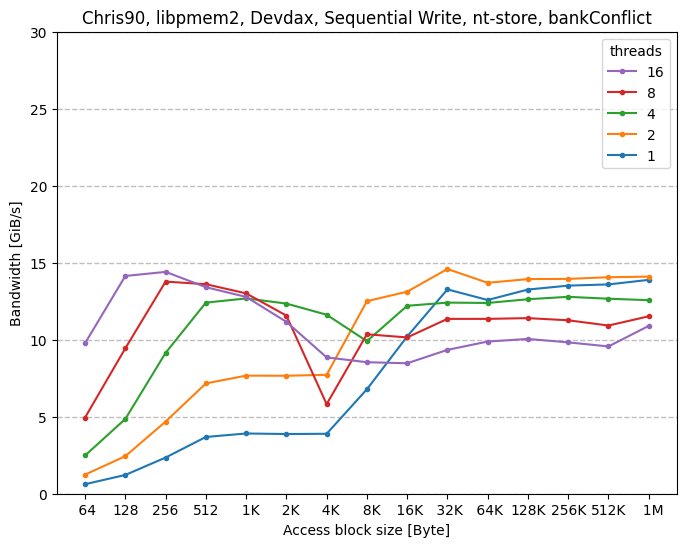

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_8329/1275652942.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


('pegasus', 'devdax', 'write', 'libpmem2', 'sequential', np.True_, np.False_, np.True_)


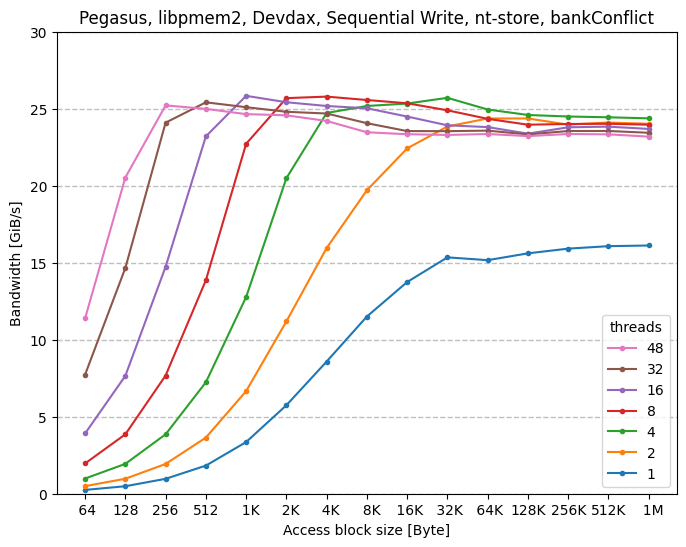

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [6]:
df = grouper.max().reset_index()

ymax = df.groupby(["accessType"]).max()["byte_per_sec"].apply(lambda x: x / 2**30).apply(lambda x: x + -x % 5).astype('int').to_dict()

for idx, df_sub in df.query(
    # "platform == 'chris80'"
    " source == 'devdax'"
    " and accessPattern == 'sequential'"
    " and accessType == 'write'"
    " and nonTemporal == True"
    " and not (accessType == 'read' and noflush == False)").groupby(["platform", "source", "accessType", "api", "accessPattern", "nonTemporal", "noflush", "bankConflict"]):
    print(idx)
    platform, source, access_type, api, access_pattern, is_nt, is_noflush, bankConflict = idx
    # display(df_sub)
    df_sub["GiB/s"] = df_sub["byte_per_sec"] / 2**30
    df_plot = df_sub.pivot(index="blockSize", columns="nthreads", values="GiB/s")
    # display(df_plot)

    fig = plt.figure(figsize=(8,6), dpi=100)
    fig.patch.set_alpha(1)

    ax = df_plot.plot(
        ax=fig.add_subplot(),
        xlabel="Access block size [Byte]",
        ylabel="Bandwidth [GiB/s]",
        ylim=[0, ymax[access_type]],
        style=".-",
        legend=access_type == "write",
    )
    if is_nt:
        store_type = ", nt-store"
    elif is_noflush:
        store_type = ", noflush"
    else:
        store_type = ", store and flush"

    ax.set_title(f"{platform.capitalize()}, {api}, {source.capitalize()}, {access_pattern.capitalize()} {access_type.capitalize()}{store_type}{', bankConflict' if bankConflict else ''}")
    ax.set_xscale("log", base=2)
    ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
    ax.grid(which = "major", axis = "y", alpha = 0.8,
        linestyle = "--", linewidth = 1)

    if idx[2] == "write":
        handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
        ax.legend(title='threads', handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示
        # ax.legend(handles=handles[::-1],labels=list(map(lambda x: f"{x} proc{'s' if int(x) > 1 else ''}", labels[::-1])))# 判例を逆順に表示
    
    fig.show()
    plt.show()
    ax.set_title("")
    save(fig, f"pmembench-{platform}-{api}-{source}-{access_type}-{access_pattern}{'-movnt' if is_nt else ''}{'-noflush' if is_noflush else ''}{'-bankConflict' if bankConflict else ''}")

In [7]:
df = df_filtered.query("success == True").drop(["path", "granularity", "set-affinity", "addr", "success", "loadApi"], axis=1)
df = df.query("platform != 'cygnus' and source == 'devdax' and ((accessType == 'write' and nonTemporal == True) or (accessType == 'read' and noflush == True))")

# max throuput
max_throuput_groupby = ["platform", "source", "accessType", "api", "accessPattern", "nonTemporal", "noflush", "blockSize"]
max_throuput_grouper = df.groupby(max_throuput_groupby)

df_max = df.loc[max_throuput_grouper["byte_per_sec"].idxmax()]

df_max["GiB/s"] = df_max["byte_per_sec"] / 2**30

# for idx, dfsub in max_throuput_grouper:
#     print(idx)

{'read': 90, 'write': 30}


,Optane 100 random,Optane 100 sequential,Optane 200 random,Optane 200 sequential,Optane 300 random (libc),Optane 300 random,Optane 300 sequential
blockSize,,,,,,,
64,3.860507,28.795378,4.945427,26.980171,35.759426,15.487617,65.365241
128,7.209307,31.608222,9.183886,28.322333,44.581031,32.379168,68.421875
256,13.160624,33.207738,16.398986,26.444562,60.542520,47.549576,75.459507
512,19.313919,32.068962,16.503700,27.609569,61.697388,59.064706,74.843492
1024,14.248476,33.464826,23.418277,36.205377,49.283609,56.373834,77.687225
2048,20.029879,35.389036,26.233363,35.613260,56.942540,64.413610,77.306367
4096,25.731961,34.782895,29.938739,26.908168,63.720457,75.736946,78.111622
8192,27.282681,35.218710,29.180483,34.992700,64.327501,77.540808,80.309346
16384,28.114478,34.803250,32.311608,38.571662,72.312425,77.510782,78.924996


/tmp/ipykernel_8329/2516929817.py:72: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


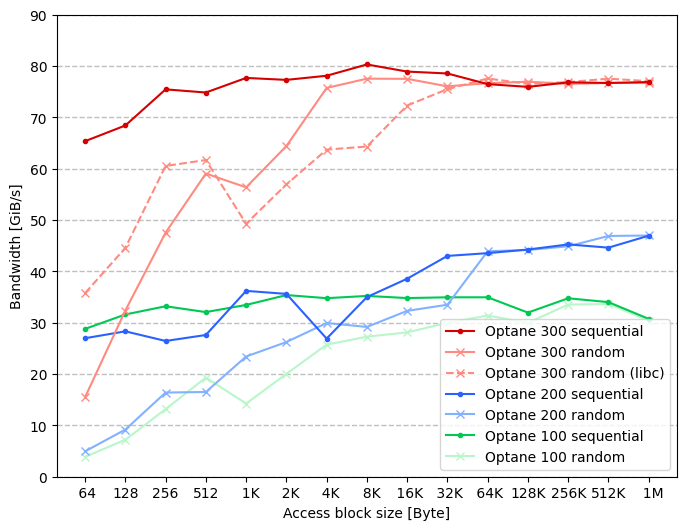

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


,Optane 100 random,Optane 100 sequential,Optane 200 random,Optane 200 sequential,Optane 300 random,Optane 300 sequential
blockSize,,,,,,
64,2.594522,7.882622,3.747542,9.776404,11.270049,11.386552
128,4.987624,9.892309,7.274849,14.140141,18.749892,20.532863
256,10.024866,11.333293,13.685373,14.405331,22.971971,25.216563
512,9.977394,11.403345,13.178391,13.605366,24.186692,25.415045
1024,9.702792,11.507365,12.279865,13.009672,24.528070,25.836094
2048,9.463000,11.550899,11.382088,12.347820,24.703649,25.686861
4096,8.833155,11.514266,9.757564,11.622869,24.656087,25.786644
8192,9.657913,11.542425,10.176946,12.502830,24.566085,25.565717
16384,10.191523,11.545418,11.313746,13.121214,24.773886,25.354389


/tmp/ipykernel_8329/2516929817.py:72: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


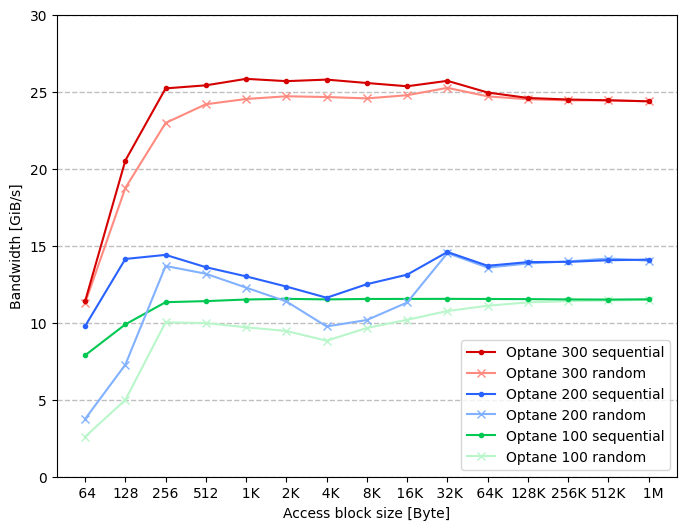

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
df = df_max

ymax = df.groupby(["accessType"]).max()["byte_per_sec"].apply(lambda x: x / 2**30).apply(lambda x: x + -x % 5).astype('int').to_dict()
ymax["read"] = 90
print(ymax)

platform_list = ["chris80", "chris90", "pegasus"]
# blocksize_list = [64, 256, 4*1024, 128*1024]
blocksize_list = [2**x for x in range(6, 21)]

df = df.loc[df.blockSize.isin(blocksize_list)]

color = {
    "read": [
        "#B9F6CA",
        "#00C853",
        "#82b1ff",
        "#2962ff",
        "#ff8a80", 
        "#ff8a80", 
        "#d50000",
    ],
    "write": [
        "#B9F6CA",
        "#00C853",
        "#82b1ff",
        "#2962ff",
        "#ff8a80", 
        "#d50000",
    ]
}

style = {
    "read": [ "x-", ".-", "x-", ".-", "x--", "x-", ".-" ],
    "write": [ "x-", ".-", "x-", ".-", "x-", ".-" ],
}

for accessType in ["read", "write"]:
    df_plot = pd.concat([
        df_sub.set_index("blockSize")["GiB/s"].rename(f"{idx[0]} {idx[1]}{' (libc)' if idx[2] == 'libc' else ''}")
        for platform in platform_list
        for idx, df_sub in df[(df.accessType == accessType) & (df.platform == platform)].groupby(["device", "accessPattern", "api"])
        if idx[2] == 'libpmem2' or (idx[2] == 'libc' and platform == 'pegasus' and idx[1] == 'random')
    ], axis=1)

    # df_plot.index = df_plot.index.map(lambda x: pretty_fmt(x, suffix=""))

    display(df_plot)

    fig = plt.figure(figsize=(8, 6), dpi=100)
    fig.patch.set_alpha(1)

    ax = df_plot.plot(
        # kind="bar",
        ax=fig.add_subplot(),
        rot=0,
        xlabel="Access block size [Byte]",
        ylabel="Bandwidth [GiB/s]",
        ylim=[0, ymax[accessType]],
        style=style[accessType],
        color=color[accessType],
    )
    
    # ax.set_title(f"Devdax {accessType.capitalize()} {'( nt-store )' if accessType == 'write' else ''}")
    ax.set_xscale("log", base=2)
    ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
    ax.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)

    handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
    ax.legend(handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示

    fig.show()
    plt.show()
    save(fig, f"pmembench-comp-devdax-{accessType}")

device,accessType,blockSize,optThreadBW,nthreads,maxThreadBW
str,str,i64,f64,i64,f64
"""Optane 100""","""read""",256,35.656537,16,35.656537
"""Optane 100""","""read""",512,34.433785,16,34.433785
"""Optane 100""","""read""",1024,35.932583,16,35.932583
"""Optane 100""","""read""",2048,37.998689,16,37.998689
"""Optane 100""","""read""",4096,37.347849,16,37.347849
…,…,…,…,…,…
"""Optane 300""","""write""",65536,26.788488,48,25.079397
"""Optane 300""","""write""",131072,26.407648,48,24.93402
"""Optane 300""","""write""",262144,26.300339,48,25.080888


write


,Optane 300 opt,Optane 300 all,Optane 200 opt,Optane 200 all,Optane 100 opt,Optane 100 all
blockSize,,,,,,
256,27.076078,27.076078,15.467607,15.467607,12.169030,11.001617
512,27.289197,26.831977,14.608650,14.400310,12.244248,11.078333
1024,27.741295,26.466285,13.969029,13.720606,12.355939,10.945552
2048,27.581057,26.383501,13.258370,11.985336,12.402683,10.375213
4096,27.688198,25.989564,12.479961,9.504913,12.363349,9.775334
8192,27.450980,25.202329,13.424811,9.169876,12.393585,9.182750
16384,27.224068,25.064680,14.088797,9.095156,12.396798,8.682895
32768,27.602835,25.015649,15.667688,10.029189,12.400386,8.525723
65536,26.788488,25.079397,14.706091,10.610089,12.392607,8.521402


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


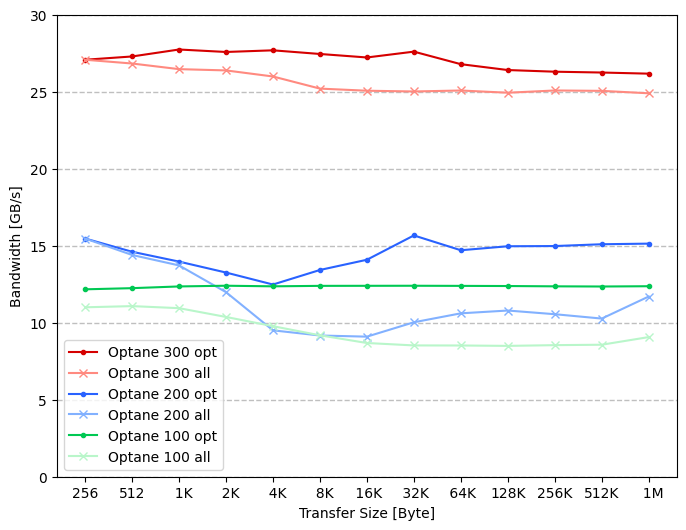

read


,Optane 300 opt,Optane 300 all,Optane 200 opt,Optane 200 all,Optane 100 opt,Optane 100 all
blockSize,,,,,,
256,83.053280,83.053280,28.394632,28.394632,35.656537,35.656537
512,82.604936,82.604936,29.645549,29.645549,34.433785,34.433785
1024,83.416022,83.416022,38.875227,38.875227,35.932583,35.932583
2048,83.007080,83.007080,38.239447,38.239447,37.998689,37.998689
4096,83.871715,83.871715,28.892425,26.008717,37.347849,37.347849
8192,86.231504,86.231504,37.573126,37.573126,37.815802,37.815802
16384,84.745069,84.745069,41.416006,41.416006,37.369705,37.369705
32768,84.345813,84.345813,46.186914,46.186914,37.528060,37.528060
65536,86.031304,86.031304,46.764586,46.764586,37.529596,37.529596


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


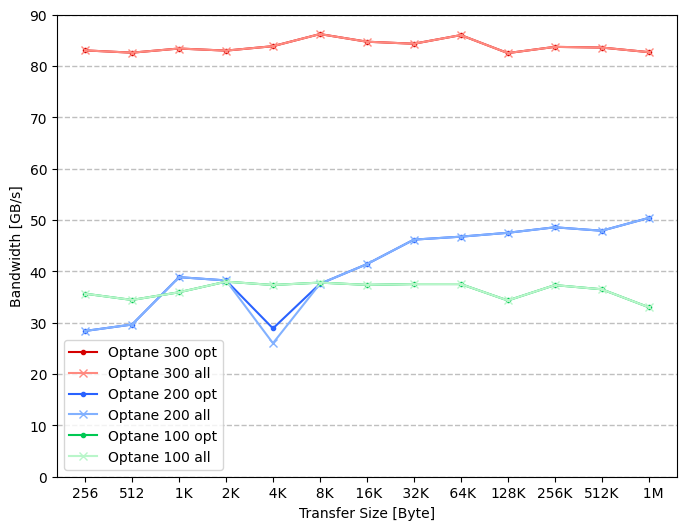

In [9]:
groupby = ["device", "accessType", "nthreads", "blockSize"]
device_list = ["Optane 300", "Optane 200", "Optane 100"]
df = (
    pl.DataFrame(df_filtered)
    .filter(
        pl.col("success") == True,
        pl.col("source") == "devdax",
        pl.col("accessPattern") == "sequential",
        (pl.col("accessType") == "write") & (pl.col("nonTemporal") == True)
        | (pl.col("accessType") == "read") & (pl.col("noflush") == True),
        pl.col("blockSize") >= 256,
        pl.col("device").is_in(device_list),
    )
    .select(groupby + ["byte_per_sec"])
    .group_by(groupby)
    .agg(bw=pl.max("byte_per_sec") / 10**9)
    .sort(groupby)
    .pipe(
        lambda df: (
            df.group_by(["device", "accessType", "blockSize"])
            .agg(optThreadBW=pl.max("bw"), nthreads=pl.max("nthreads"))
            .join(df, on=["device", "accessType", "nthreads", "blockSize"], how="inner")
            .rename({"bw": "maxThreadBW"})
        )
    )
)

display(df)

for access in ["write", "read"]:
    print(access)
    fig = plt.figure(figsize=(8, 6), dpi=100)
    fig.patch.set_alpha(1)
    df_plot = (
        df.filter(pl.col("accessType") == access)
        .sort("device", descending=True)
        # .pivot(values=["optThreadBW", "maxThreadBW"], columns=["device"], index="blockSize")
        # .pipe(lambda df: (display(df), df)[-1])
        .to_pandas()
        .pivot(
            index="blockSize", columns="device", values=["optThreadBW", "maxThreadBW"]
        )
        # .set_index("blockSize")
    )
    df_plot.columns = [
        f'{col} {"opt" if val == "optThreadBW" else "all"}'
        for val, col in df_plot.columns
    ]

    ax = (
        df_plot.loc[
            :,
            [
                f"{dev} {th}"
                for dev in device_list
                for th in ["opt", "all"]
            ],
        ]
        .pipe(lambda df: (display(df), df)[-1])
        .plot(
            ax=fig.add_subplot(),
            xlabel="Transfer Size [Byte]",
            ylabel="Bandwidth [GB/s]",
            style=[".-", "x-"] * 3,
            color=[
                "#d50000",
                "#ff8a80",
                "#2962ff",
                "#82b1ff",
                "#00C853",
                "#B9F6CA",
            ],
            # title=f"Single Node, Multithreading, Devdax {access.capitalize()}",
        )
    )
    ax.grid(which="major", axis="y", alpha=0.8, linestyle="--", linewidth=1)
    ax.set_xscale("log", base=2)
    ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
    ax.set_ylim(0, 90 if access == "read" else 30)
    save(fig, f"pmembench-devdax-{access}-bw-comp-opt-all")
    plt.show()